<a href="https://colab.research.google.com/github/plodha/CMPE-297-DeepLearning/blob/main/AlphaGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlphaGAN

In [4]:
import os
import time
import torch
import datetime
import itertools
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.transforms import ToPILImage
from tensorboardX import SummaryWriter
from torchsummary import summary

from alphagan_models import Generator, Discriminator, Encoder, Codecriminator
from spectral import SpectralNorm
from utils import *


from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import tester
from data_loader import Data_Loader
from utils import denorm

In [14]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [17]:
!nvidia-smi

Thu Dec  3 22:44:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
batch_size = 64
G = Generator(batch_size, 64, 128, 64).to(device)
E = Encoder(batch_size, 64, 128, 64).to(device)
D = Discriminator(batch_size, 128, 64).to(device)

In [30]:
ds = Data_Loader(train=False, dataset='mura', mura_class='XR_WRIST', mura_type='', 
                 image_path='/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/', image_size=64, batch_size=64)
dl = ds.loader()

Dataset lengh:  659


In [31]:
model_save_path = '/content/drive/Shareddrives/MeanSquare-Drive/Advanced-DeepLearning/Alpha Gan Results/models/sabigan_wrist/29900'
G.load_state_dict(torch.load(model_save_path + '_G.pth', map_location=torch.device('cpu')))
E.load_state_dict(torch.load(model_save_path + '_E.pth', map_location=torch.device('cpu')))
D.load_state_dict(torch.load(model_save_path + '_D.pth', map_location=torch.device('cpu')))
print('loaded trained models (step: {})..!'.format(model_save_path))

loaded trained models (step: /content/drive/Shareddrives/MeanSquare-Drive/Advanced-DeepLearning/Alpha Gan Results/models/sabigan_wrist/29900)..!


In [32]:
data_iter = iter(dl)
with torch.no_grad(): 
    le1 = []
    le2 = []
    l1 = []
    l2 = []
    ld = []
    ld5 = []
    ld4 = []
    ld3 = []
    labels = []
    
    for i, data in enumerate(data_iter):
        val_images, val_labels = data
        val_images = tensor2var(val_images)
        labels.append(val_labels)

        # Run val images through models X -> E(X) -> G(E(X))
        mean_z, mean_logvar, ef1, ef2 = E(val_images)
        z = mean_z + mean_logvar * torch.randn(mean_z.size()) #.cuda() add this back if you want gpu
        rec_images, gf1, gf2 = G(z)

        d_real, d_real4, d_real3 = D(val_images)
        d_rec, d_rec4, d_rec3 = D(rec_images)

        # Compute Encoder features matching loss
        le1.append(ef1.view(ef1.size(0), -1).mean(dim=-1))
        le2.append(ef2.view(ef2.size(0), -1).mean(dim=-1))
        # Compute residual loss 
        l1.append((val_images - rec_images).abs().view(val_images.size(0), -1).mean(dim=-1))
        l2.append((val_images - rec_images).pow(2).sqrt().view(val_images.size(0), -1).mean(dim=-1))
        # Computer feature matching loss
        ld.append((d_real - d_rec).view((d_real.size(0), -1)).mean(dim=1))
        ld4.append((d_real4 - d_rec4).view((d_real4.size(0), -1)).mean(dim=1))
        ld3.append((d_real3 - d_rec3).view((d_real3.size(0), -1)).mean(dim=1))

    le1 = np.stack(torch.cat(le1).cpu().data)
    le2 = np.stack(torch.cat(le2).cpu().data)
    l1 = np.stack(torch.cat(l1).cpu().data)
    l2 = np.stack(torch.cat(l2).cpu().data)
    ld = np.stack(torch.cat(ld).cpu().data)
    ld4 = np.stack(torch.cat(ld4).cpu().data)
    ld3 = np.stack(torch.cat(ld3).cpu().data)
    labels = np.stack(torch.cat(labels).cpu().data)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


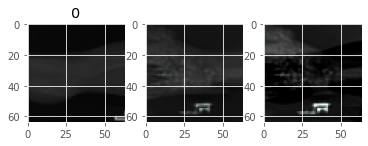

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


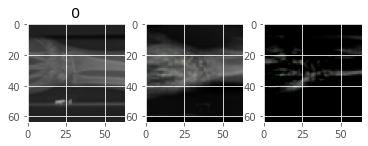

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


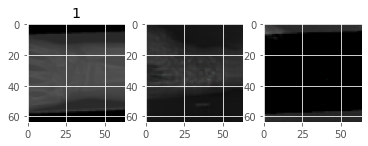

In [33]:
for i in range(3):
    plt.subplot(131)
    plt.imshow(denorm(val_images[i]).transpose(0,2))
    plt.title(labels[i])
    plt.subplot(132)
    plt.imshow(denorm(rec_images[i]).transpose(0,2))
    plt.subplot(133)
    plt.imshow(((rec_images[i]-val_images[i])).transpose(0,2))
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate

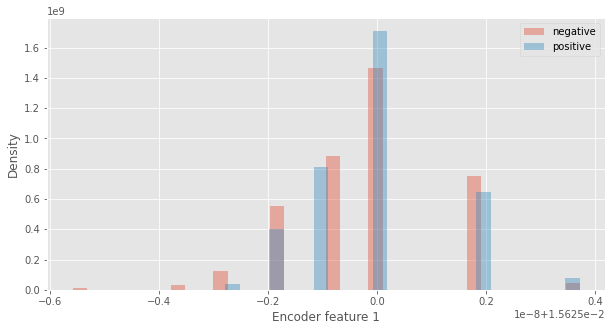

In [34]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
sns.distplot(le1[labels==0], hist=True, label='negative')
sns.distplot(le1[labels==1].clip(min=None, max=0.10), hist=True, label='positive')
plt.xlabel('Encoder feature 1')
plt.ylabel('Density')
plt.legend()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate

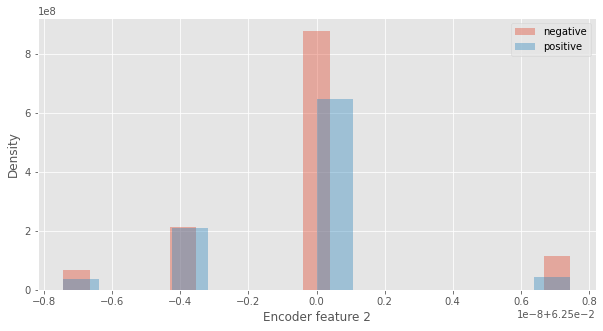

In [35]:
plt.figure(figsize=(10, 5))
sns.distplot(le2[labels==0], hist=True, label='negative')
sns.distplot(le2[labels==1].clip(min=None, max=0.10), hist=True, label='positive')
plt.xlabel('Encoder feature 2')
plt.ylabel('Density')
plt.legend()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


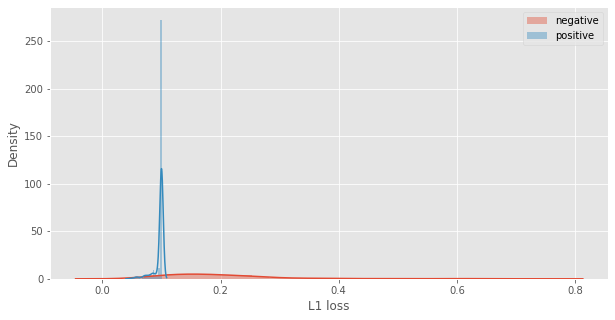

In [36]:
plt.figure(figsize=(10, 5))
sns.distplot(l1[labels==0], hist=True, label='negative')
sns.distplot(l1[labels==1].clip(min=None, max=0.10), hist=True, label='positive')
plt.xlabel('L1 loss')
plt.ylabel('Density')
plt.legend()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


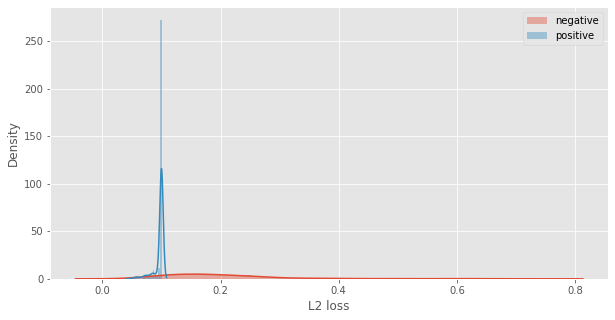

In [37]:
plt.figure(figsize=(10, 5))
sns.distplot(l2[labels==0], hist=True, label='negative')
sns.distplot(l2[labels==1].clip(min=None, max=0.10), hist=True, label='positive')
plt.xlabel('L2 loss')
plt.ylabel('Density')
plt.legend()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


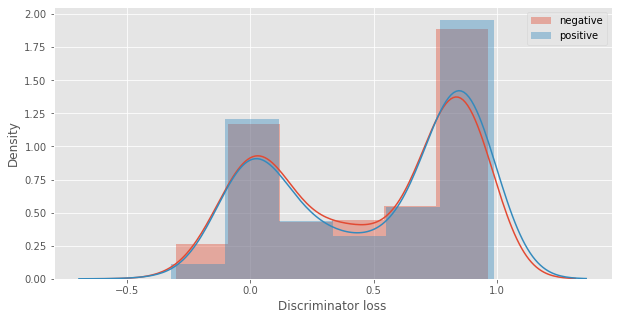

In [38]:
plt.figure(figsize=(10, 5))
sns.distplot(ld[labels==0], hist=True, label='negative')
sns.distplot(ld[labels==1], hist=True, label='positive')
plt.xlabel('Discriminator loss')
plt.ylabel('Density')
plt.legend()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


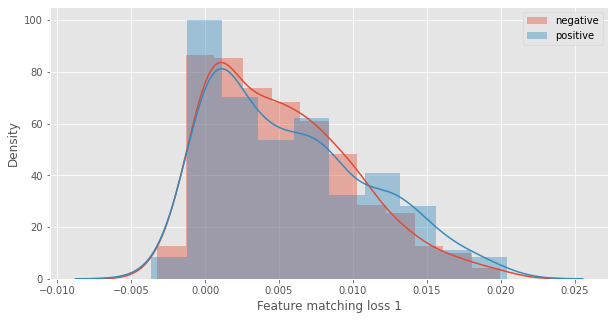

In [39]:
plt.figure(figsize=(10, 5))
sns.distplot(ld4[labels==0], hist=True, label='negative')
sns.distplot(ld4[labels==1], hist=True, label='positive')
plt.xlabel('Feature matching loss 1')
plt.ylabel('Density')
plt.legend()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


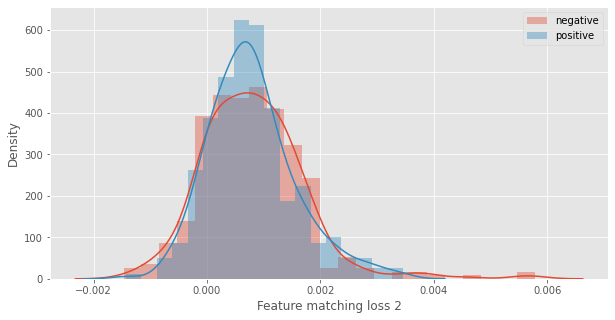

In [40]:
plt.figure(figsize=(10, 5))
sns.distplot(ld3[labels==0].clip(min=-0.01, max=0.01), hist=True, label='negative')
sns.distplot(ld3[labels==1].clip(min=-0.01, max=0.01), hist=True, label='positive')
plt.xlabel('Feature matching loss 2')
plt.ylabel('Density')
plt.legend()

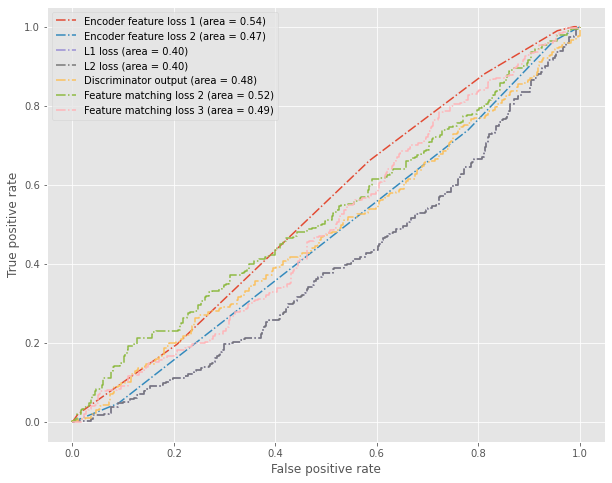

In [41]:
plt.figure(figsize=(10, 8))
fpr, tpr, thresh = roc_curve(labels, le1)
auc = roc_auc_score(labels, le1)
plt.plot(fpr, tpr, '-.', label=f'Encoder feature loss 1 (area = {auc:.2f})')

fpr, tpr, thresh = roc_curve(labels, le2)
auc = roc_auc_score(labels, le2)
plt.plot(fpr, tpr, '-.', label=f'Encoder feature loss 2 (area = {auc:.2f})')

fpr, tpr, thresh = roc_curve(labels, l1)
auc = roc_auc_score(labels, l1)
plt.plot(fpr, tpr, '-.', label=f'L1 loss (area = {auc:.2f})')

fpr, tpr, thresh = roc_curve(labels, l2)
auc = roc_auc_score(labels, l2)
plt.plot(fpr, tpr, '-.', label=f'L2 loss (area = {auc:.2f})')

fpr, tpr, thresh = roc_curve(labels, -ld)
auc = roc_auc_score(labels, -ld)
plt.plot(fpr, tpr, '-.', label=f'Discriminator output (area = {auc:.2f})')

fpr, tpr, thresh = roc_curve(labels, ld4)
auc = roc_auc_score(labels, ld4)
plt.plot(fpr, tpr, '-.', label=f'Feature matching loss 2 (area = {auc:.2f})')
                    
fpr, tpr, thresh = roc_curve(labels, ld3)
auc = roc_auc_score(labels, ld3)
plt.plot(fpr, tpr, '-.', label=f'Feature matching loss 3 (area = {auc:.2f})')
                    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()